In [1]:
#directions = [5,15,20,25,35]
#labels = ['extremeleft','left','middle','right','extremeright']

directions = [0,5,10,15,20,25,30,35]
N = len(directions)
#labels = ['baseline','5','10','15','middle','25','30','extremeright']
#labeldict = dict(zip(directions,labels))

n_each = 20 #15

In [2]:
N_PARALLEL = 28 # for parallel processing, how many cores can we use

In [3]:
%pylab inline
import random
import pandas as pd
import numpy as np
import time
import multiprocessing
import ctypes
import numpy as np
from IPython.display import display, clear_output
import seaborn as sns
import os

Populating the interactive namespace from numpy and matplotlib


In [4]:
def create_random_design():
    dirs = []
    lastdir = None
    for _ in range(n_each):
        acceptable = False
        while not acceptable:
            d = list(range(N)) #directions[:]
            random.shuffle(d)
            acceptable = d[0]!=lastdir
        lastdir=d[-1]
        dirs+=d
    return dirs

In [5]:
dirs = create_random_design()
" ".join([str(directions[d]) for d in dirs ])

'30 0 35 25 10 15 20 5 35 5 15 10 0 30 20 25 30 25 10 15 35 5 20 0 35 25 5 15 30 0 20 10 20 35 5 10 0 25 15 30 25 10 20 5 30 35 0 15 20 35 5 15 10 0 25 30 25 35 10 30 0 15 20 5 20 5 15 30 35 25 10 0 10 35 15 30 5 0 20 25 30 35 25 5 15 10 0 20 30 5 10 20 35 0 25 15 0 20 25 35 30 15 5 10 35 0 5 30 20 15 25 10 15 25 30 35 10 5 20 0 5 35 25 20 30 10 15 0 10 30 25 15 35 5 20 0 15 0 35 25 30 20 5 10 20 35 15 0 5 25 30 10 30 10 20 5 0 25 35 15'

In [6]:
len(dirs)

160

## What are the carry-over effects?

In [7]:
def get_transitions(dirs):
    # Get the first-order transition matrix
    trans = [ (dirs[i],dirs[i+1]) for i in range(len(dirs)-1) ]
    #n = len(directions)
    transcount = np.zeros((N,N))
    for i in range(len(dirs)-1):
        transcount[dirs[i],dirs[i+1]]+=1
    return transcount

In [8]:
transcount = get_transitions(dirs)
transcount

array([[0., 3., 2., 3., 4., 4., 1., 3.],
       [2., 0., 4., 5., 4., 1., 2., 2.],
       [5., 1., 0., 4., 5., 0., 3., 2.],
       [4., 1., 3., 0., 3., 2., 4., 2.],
       [3., 6., 1., 1., 0., 3., 2., 4.],
       [0., 2., 5., 3., 1., 0., 6., 3.],
       [3., 2., 3., 1., 3., 4., 0., 4.],
       [3., 5., 2., 3., 0., 6., 1., 0.]])

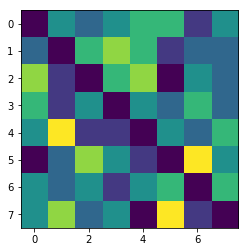

In [9]:
imshow(transcount)

In [10]:
sum(transcount,0)

array([20., 20., 20., 20., 20., 20., 19., 20.])

In [11]:
#sum(transcount,0)

In [12]:
20./7

2.857142857142857

In [13]:
3*6+1*2

20

## Batch-generate schedules and pick the best one
Generations of scholars will wonder why on Earth we do this, but hey...

In [14]:
def badness(mat):
    # Tell us how bad this transition matrix is - how unequal are the transitional probability distributions?
    
    # Compute the average of each row
    mat = np.array(mat)
    n,_ = mat.shape
    # Restrict to the off-diagonal elements 
    rowvalues = [ vals[sel] for (vals,sel) in zip(mat,(1-np.eye(n)).astype(bool)) ]
    
    # Compute the deviation of each item from the average for that row
    dists = [ [ abs(r-np.mean(row)) for r in row ] for row in rowvalues ]
    
    return sum(np.array(dists).flatten())

In [15]:
badness(transcount)

68.57142857142856

### What is the best badness we can expect?

In [16]:
theo = 3*(ones((N,N))*(1-eye(N)))
for i in range(N):
    if i==3:
        theo[i,4]=2
        theo[i,2]=2
    else:
        theo[i,3]=2

In [17]:
theo

array([[0., 3., 3., 2., 3., 3., 3., 3.],
       [3., 0., 3., 2., 3., 3., 3., 3.],
       [3., 3., 0., 2., 3., 3., 3., 3.],
       [3., 3., 2., 0., 2., 3., 3., 3.],
       [3., 3., 3., 2., 0., 3., 3., 3.],
       [3., 3., 3., 2., 3., 0., 3., 3.],
       [3., 3., 3., 2., 3., 3., 0., 3.],
       [3., 3., 3., 2., 3., 3., 3., 0.]])

In [18]:
#sum(theo)

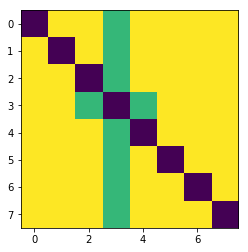

In [19]:
imshow(theo)

In [20]:
sum(theo,1)

array([20., 20., 20., 19., 20., 20., 20., 20.])

In [21]:
LOWEST = badness(theo)
LOWEST

14.857142857142854

In [22]:
#N_DESIGNS = 1000000 # Neeraj wanted 100000000
N_DESIGNS = 10000

# Distribution of badnesses
shared_array_base = multiprocessing.Array(ctypes.c_double, N_DESIGNS)
shared_array = np.ctypeslib.as_array(shared_array_base.get_obj())
#shared_array = shared_array.reshape(10, 10)

# Best the design
shared_design_base = multiprocessing.Array(ctypes.c_int, n_each*len(directions))
shared_design = np.ctypeslib.as_array(shared_design_base.get_obj())

bestbad = multiprocessing.Value('d', 999999)


def generate_random(i,allbadness=shared_array,bestdesign=shared_design,bestb=bestbad):
    #print(i)
    design = create_random_design()
    trans = get_transitions(design)
    howbad = badness(trans)
    allbadness[i]=howbad
    if howbad<bestb.value:
        bestb.value=howbad
        for j,v in enumerate(design):
            shared_design[j]=v
    if i%100000==0:
        print("{} best {}".format(i,bestbad.value))
    return 

# Parallel processing
#def my_func(i, def_param=shared_array):
#    shared_array[i,:] = i

t0 = time.time()

pool = multiprocessing.Pool(processes=N_PARALLEL)
pool.map(generate_random, range(N_DESIGNS))

tsec = (time.time()-t0)
tdur = tsec/(60*60)

print("This took {} seconds i.e. {} hours for {} designs".format(tsec,tdur,N_DESIGNS))
targetdes = 100000000
print("At this rate {} will take {} hours.".format(targetdes,targetdes*tdur/N_DESIGNS))

#print(shared_array)
#bestbad_posthoc = min(shared_array)
#print(bestbad_posthoc,bestbad.value)

0 best 66.0
This took 0.588712930679 seconds i.e. 0.000163531369633 hours for 10000 designs
At this rate 100000000 will take 1.63531369633 hours.


37.7142857143


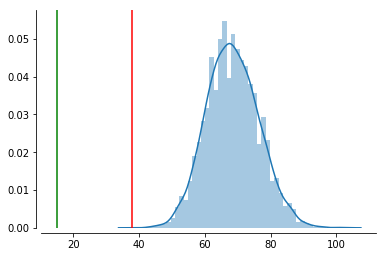

In [23]:
sns.distplot(shared_array[:1000000])
axvline(x=bestbad.value,color='red')
axvline(x=LOWEST,color='green')
sns.despine(offset=5)
print(bestbad.value)


In [24]:
dirs = list(shared_design)

In [25]:
transcount = get_transitions(dirs)
transcount

array([[0., 3., 1., 4., 3., 3., 3., 3.],
       [3., 0., 3., 3., 1., 3., 3., 4.],
       [3., 2., 0., 2., 5., 3., 3., 2.],
       [4., 2., 2., 0., 3., 2., 3., 4.],
       [2., 5., 2., 3., 0., 3., 2., 3.],
       [3., 2., 5., 3., 2., 0., 2., 3.],
       [2., 4., 4., 2., 3., 3., 0., 1.],
       [3., 2., 2., 3., 3., 3., 4., 0.]])

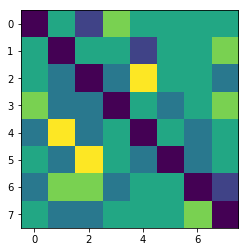

In [26]:
imshow(transcount)

In [27]:
# Let's save the history
import pickle
PICKLE_F = 'history.pickle'
if os.path.exists(PICKLE_F):
    history = pickle.load(open(PICKLE_F,'rb'))
else:
    history = []
history.append({"source":"bruteforce","best_design":list(shared_design)})
pickle.dump(history,open(PICKLE_F,'wb'))

Find the best design from the history...

# Making sub-designs combining them into larger ones

So the idea here is to create smaller designs that hopefully will be pretty good and then combining them into larger designs, hoping that those are good too!

In [73]:
SUBSIZE  = 10 # instead of N_EACH, we make smaller designs of SUBSIZE * directions which we try to optimize
N_SEARCH = 1000000 # create a whole lot of random small sub designs
#N_SEARCH = 1000
N_PICK   = 1000 # subset of the best of the N_SEARCH designs from which we start making our MASTER design

In [74]:
assert n_each%SUBSIZE==0

In [75]:
MINI_SIZE = SUBSIZE*len(directions) # how big a mini design is

## STEP 1: GENERATE N_PICK DESIGNS

If we want to save all generated designs, we need `N_SEARCH * SUBSIZE * directions` array. That's too much, and we need to go through them anyway afterwards.

In [76]:
t0 = time.time()

# Best the design
ALLDESIGNSSIZE = N_PICK*MINI_SIZE
minidesigns_base = multiprocessing.Array(ctypes.c_int, ALLDESIGNSSIZE)
minidesigns = np.ctypeslib.as_array(minidesigns_base.get_obj())


def create_random_minidesign():
    dirs = []
    lastdir = None
    for _ in range(SUBSIZE):
        acceptable = False
        while not acceptable:
            d = list(range(N)) #directions[:]
            random.shuffle(d)
            acceptable = d[0]!=lastdir
        lastdir=d[-1]
        dirs+=d
    return dirs



def generate_random_static(i,minidesigns=minidesigns):
    current_bad = 99999
    current_design = None

    print("Iteration {}".format(i))
    
    for n in range(N_SEARCH):
        design = create_random_minidesign()
        trans = get_transitions(design)
        howbad = badness(trans)
        if howbad<current_bad:
            current_bad=howbad
            current_design = design[:]
    #print(current_design)
    
    # The result of this function is a "good" mini-design
    # Insert it into the current list of minidesigns
    x = i*MINI_SIZE
    for j,d in enumerate(current_design):
        minidesigns[x+j]=d
        
    return


pool = multiprocessing.Pool(processes=N_PARALLEL)
pool.map(generate_random_static, range(N_PICK))
#pool.map(generate_random_static, range(2))
            
tsec = (time.time()-t0)
tdur = tsec/(60*60)

print("This took {} seconds i.e. {} hours".format(tsec,tdur))

Iteration 36
Iteration 45
Iteration 27
Iteration 63
Iteration 54
Iteration 0
Iteration 72
Iteration 18
Iteration 90
Iteration 9
Iteration 81
Iteration 99
Iteration 117
Iteration 108
Iteration 135
Iteration 126
Iteration 144
Iteration 243
Iteration 153
Iteration 162
Iteration 171
Iteration 180
Iteration 189
Iteration 198
Iteration 207
Iteration 216
Iteration 234
Iteration 225
Iteration 118
Iteration 127
Iteration 1
Iteration 136
Iteration 244
Iteration 82
Iteration 226
Iteration 109
Iteration 208
Iteration 73
Iteration 181
Iteration 28
Iteration 190
Iteration 217
Iteration 19
Iteration 100
Iteration 172
Iteration 10
Iteration 91
Iteration 145
Iteration 55
Iteration 163
Iteration 46
Iteration 154
Iteration 64
Iteration 235
Iteration 37
Iteration 199
Iteration 119
Iteration 182
Iteration 137
Iteration 128
Iteration 2
Iteration 11
Iteration 47
Iteration 38
Iteration 245
Iteration 83
Iteration 227
Iteration 20
Iteration 110
Iteration 209
Iteration 29
Iteration 74
Iteration 191
Iteration 218

Iteration 535
Iteration 713
Iteration 704
Iteration 642
Iteration 624
Iteration 579
Iteration 597
Iteration 544
Iteration 722
Iteration 740
Iteration 517
Iteration 526
Iteration 660
Iteration 669
Iteration 731
Iteration 749
Iteration 687
Iteration 509
Iteration 633
Iteration 651
Iteration 678
Iteration 536
Iteration 589
Iteration 562
Iteration 553
Iteration 696
Iteration 607
Iteration 527
Iteration 616
Iteration 750
Iteration 571
Iteration 580
Iteration 705
Iteration 714
Iteration 643
Iteration 510
Iteration 625
Iteration 688
Iteration 723
Iteration 598
Iteration 670
Iteration 537
Iteration 545
Iteration 661
Iteration 741
Iteration 518
Iteration 732
Iteration 634
Iteration 563
Iteration 652
Iteration 679
Iteration 590
Iteration 581
Iteration 626
Iteration 706
Iteration 554
Iteration 662
Iteration 697
Iteration 617
Iteration 608
Iteration 546
Iteration 528
Iteration 715
Iteration 751
Iteration 572
Iteration 599
Iteration 689
Iteration 644
Iteration 724
Iteration 511
Iteration 653
Iterat

In [77]:
minidesigns = minidesigns.reshape( (N_PICK,MINI_SIZE) )

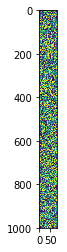

In [78]:
imshow(minidesigns)

In [79]:
minidesigns = [ list(minidesigns[i,:]) for i in range(N_PICK) ]

In [80]:
def design_to_badness(d):
    if sum(d)==0: return 99999
    transcount = get_transitions(d)
    return badness(transcount)

37.7142857143


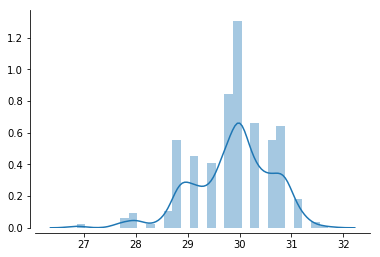

In [81]:
minibad = [ design_to_badness(md) for md in minidesigns ]

sns.distplot(minibad)
#axvline(x=bigbestbadness,color='red')
#axvline(x=LOWEST,color='green')
sns.despine(offset=5)
print(bestbad.value)


In [82]:
#minidesigns
if False:
    pickle.dump(minidesigns,open('minidesigns.pickle','wb'))

## STEP 2: COMBINE CHILDREN TO MAKE MASTER DESIGN

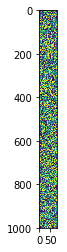

In [83]:
matrix(minidesigns)
imshow(minidesigns)

In [84]:
#minidesigns[0]'Iteration 532 badness 28.5714285714'

In [85]:
def create_master_design():
    # randomly create master design from the children
    # but check that the edges align, i.e. that we don't create
    # transitions from a particular direction to itself
    
    des = []
    while len(des)<n_each*len(directions):
        
        # concatenate another design
        mini = random.choice(minidesigns)
        
        # can we actually append this?
        if len(des) and des[-1]==mini[0]:
            continue # we cannot append this!
        
        des += mini

    return des

In [86]:
#minidesigns[1]

In [87]:
m = create_master_design()

In [88]:
len(m)

160

In [89]:
#t = get_transitions(m)[3., 3., 4., 2., 2., 2., 0., 4.],

In [90]:
#badness(t)

In [98]:
N_MONTE_CARLO = 1000000

bestmaster = None
bestmasterbad = 99999

graphbest = zeros(N_MONTE_CARLO)

for i in range(N_MONTE_CARLO):
    
    master = create_master_design() # create a master design (concat)
    
    # determine badness of master
    howbad = design_to_badness(master)
    
    # if better than before, keep it as best
    if howbad<bestmasterbad:
        bestmaster = master[:]
        bestmasterbad = howbad

    if i%100==0:
        clear_output(wait=True)
        display('Iteration {} badness {}'.format(i,bestmasterbad))
    
    graphbest[i]= bestmasterbad

'Iteration 999900 badness 16.5714285714'

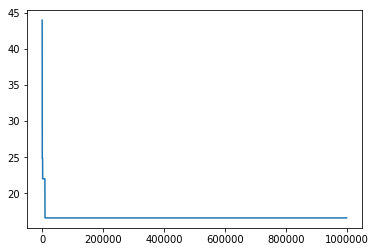

In [99]:
plot(graphbest)

In [100]:
" ".join([ str(s) for s in bestmaster])

'6 1 0 4 2 7 5 3 1 7 2 3 0 6 5 4 2 4 5 0 6 1 7 3 4 3 5 7 0 2 1 6 4 0 2 3 7 1 5 6 2 0 5 3 6 7 1 4 0 1 5 2 7 6 4 3 2 5 4 7 1 0 3 6 3 0 6 7 5 1 2 4 1 3 5 2 6 0 7 4 1 5 3 7 2 4 6 0 4 6 2 3 0 5 7 1 0 3 5 7 4 2 1 6 7 0 4 5 6 1 3 2 7 4 3 2 6 0 5 1 4 1 2 5 0 7 6 3 6 2 1 4 7 5 0 3 7 3 1 6 4 0 2 5 6 3 4 5 2 0 1 7 2 0 1 3 4 7 6 5'

In [101]:
trans = get_transitions(bestmaster)
trans

array([[0., 3., 3., 3., 3., 3., 3., 2.],
       [3., 0., 2., 3., 3., 3., 3., 3.],
       [3., 3., 0., 3., 3., 3., 2., 3.],
       [3., 2., 3., 0., 3., 3., 3., 3.],
       [3., 3., 3., 3., 0., 3., 2., 3.],
       [3., 2., 3., 3., 2., 0., 3., 3.],
       [3., 3., 3., 3., 3., 2., 0., 3.],
       [2., 4., 3., 2., 3., 3., 3., 0.]])

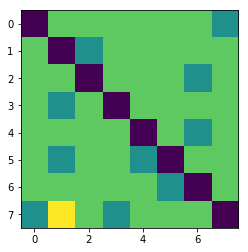

In [102]:
imshow(trans)

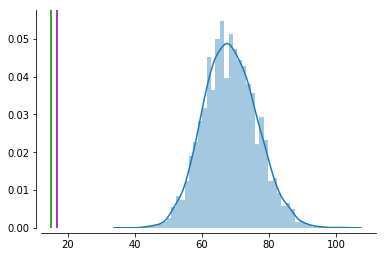

In [103]:
sns.distplot(shared_array[:1000000])
#axvline(x=bigbestbadness,color='red')
axvline(x=bestmasterbad,color='purple')
axvline(x=LOWEST,color='green')
sns.despine(offset=5)
#print(bestbad.value)

In [104]:
# Let's save the history
import pickle
PICKLE_F = 'history.pickle'
if os.path.exists(PICKLE_F):
    history = pickle.load(open(PICKLE_F,'rb'))
else:
    history = []
history.append({"minidesigns":minidesigns,"SUBSIZE":SUBSIZE,"N_SEARCH":N_SEARCH,"N_PICK":N_PICK,"source":"recombine_smaller","best_design":list(bestmaster)})
pickle.dump(history,open(PICKLE_F,'wb'))

# The whole history & Output
What is the best thing we have found using any method?

In [105]:
print("{} candidates in history".format(len(history)))

22 candidates in history


In [106]:
#design_to_badness(h['best_design'])

In [107]:
for h in history:
    h['badness']= design_to_badness(h['best_design'])
history = sorted(history, 
                 key = lambda x: x['badness'])

In [108]:
#history
bigbest = history[0]['best_design']
bigbestbadness = history[0]['badness']
bigbestbadness

16.57142857142857

In [109]:
" ".join([ str(directions[b]) for b in bigbest ])

'30 5 0 20 10 35 25 15 5 35 10 15 0 30 25 20 10 20 25 0 30 5 35 15 20 15 25 35 0 10 5 30 20 0 10 15 35 5 25 30 10 0 25 15 30 35 5 20 0 5 25 10 35 30 20 15 10 25 20 35 5 0 15 30 15 0 30 35 25 5 10 20 5 15 25 10 30 0 35 20 5 25 15 35 10 20 30 0 20 30 10 15 0 25 35 5 0 15 25 35 20 10 5 30 35 0 20 25 30 5 15 10 35 20 15 10 30 0 25 5 20 5 10 25 0 35 30 15 30 10 5 20 35 25 0 15 35 15 5 30 20 0 10 25 30 15 20 25 10 0 5 35 10 0 5 15 20 35 30 25'

37.7142857143


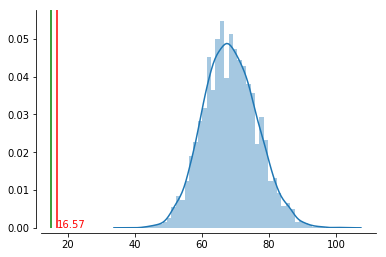

In [110]:
sns.distplot(shared_array[:1000000])
axvline(x=bigbestbadness,color='red')
axvline(x=LOWEST,color='green')
text(bigbestbadness,0,'%.2f'%bigbestbadness,color='red')
sns.despine(offset=5)
print(bestbad.value)

## Output

In [111]:
chosen = [ directions[d] for d in bigbest ]
' '.join([str(s) for s in chosen])

'30 5 0 20 10 35 25 15 5 35 10 15 0 30 25 20 10 20 25 0 30 5 35 15 20 15 25 35 0 10 5 30 20 0 10 15 35 5 25 30 10 0 25 15 30 35 5 20 0 5 25 10 35 30 20 15 10 25 20 35 5 0 15 30 15 0 30 35 25 5 10 20 5 15 25 10 30 0 35 20 5 25 15 35 10 20 30 0 20 30 10 15 0 25 35 5 0 15 25 35 20 10 5 30 35 0 20 25 30 5 15 10 35 20 15 10 30 0 25 5 20 5 10 25 0 35 30 15 30 10 5 20 35 25 0 15 35 15 5 30 20 0 10 25 30 15 20 25 10 0 5 35 10 0 5 15 20 35 30 25'

In [112]:
tab = pd.DataFrame({'direction':chosen})
tab['type']=[ 'direction{}'.format(d) for d in tab['direction']]
tab['trial']=np.arange(len(chosen))+1
#tab.to_csv('recognitionyesno_theOne.csv')
outcsv = 'recognitionyesno_bestoverall_%.2f.csv'%bigbestbadness
tab.to_csv(outcsv)
print(outcsv)

recognitionyesno_bestoverall_16.57.csv


In [113]:
tab.head()

,direction,type,trial
0,30,direction30,1
1,5,direction5,2
2,0,direction0,3
3,20,direction20,4
4,10,direction10,5


## Double-check
I know, not strictly necessary, but it sounds like a good idea to double-check what we have written out.

In [69]:
drs = pd.read_csv('recognitionyesno_efficient23.csv')['direction']
thedirs = list(set(drs))
dr = [ thedirs.index(d) for d in drs ]

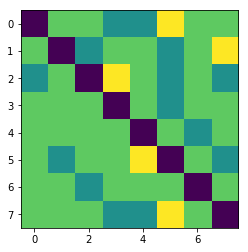

In [70]:
#drs
trans = get_transitions(dr)
imshow(trans)

In [71]:
badness(trans)

23.142857142857142

# Doing this the smart way (maybe)

In [ ]:
if True:
    #Highest number in square
    order_of_sq = int(input("Enter order of sq: "))

    #Number you want to start the square with
    top_left = int(input("Enter top left number: "))

    #Sets a placeholder for a variable called top_left_init
    top_left_init=0

    #Sets the initial value of top_left to a new variable because the code will change the value of top left later on 
    top_left_init += top_left

    #Initialize the value of count
    count = 0

    #Add 1 to the highest value in latin square to account for the range function (the ending number is always one less than the number you enter into the range function)
    for values in range (1,order_of_sq+1):

        #Prevents the program from adding too many characters to the line
        while count != order_of_sq:

            #Prints numbers with spaces after them in a horizontal manner
            print(top_left,sep=' ',end=' ')

            #Adds 1 to the top_left
            top_left += 1

            #Count is used to keep track of how many characters are in your line
            count+=1

            #Restarts the numbers in your line when you reach the highest number
            if top_left == order_of_sq+1:
                top_left = 1

        #Creates a new row
        print()
        count = 0

        #Calls the initial value of top_left and adds 1 to it before beginning the next row
        top_left_init += 1

        #Resets top_left_init to 1 if it reaches the highest number in the square
        if top_left_init == order_of_sq + 1:
            top_left_init = 1
            top_left = top_left_init
        else:
            top_left = top_left_init